In [1]:
# Imports
import gymnasium as gym
import numpy as np
import random
from environments.grid_world import GridWorldEnv
import matplotlib.pyplot as plt

In [2]:
### Deterministic GridWorld
gym.register(
    id="gymnasium_env/GridWorld-v2",
    entry_point=GridWorldEnv,
    max_episode_steps=300,  # Prevent infinite episodes
)

In [3]:
# Environment
env = gym.make("gymnasium_env/GridWorld-v2", render_mode='rgb_array')
env.reset()
num_states = env.observation_space.n
num_actions = env.action_space.n

In [12]:
# SARSA Class
class SARSA:
    def __init__(self, env, num_states, num_actions):
        self.env = env
        self.num_states = num_states
        self.num_actions = num_actions
        self.Q = np.zeros((self.num_states, self.num_actions))
        self.policy = {state: 0 for state in range(self.num_states)}

    def select_action(self, state, epsilon=.1):
        if np.random.rand() < epsilon:
            return np.random.choice(self.num_actions)
        return np.argmax(self.Q[state])

    def update_q_table(self, state, action, reward, next_state, next_action, alpha=.01, gamma=.9):
        old_q_value = self.Q[state, action]
        new_q_value = self.Q[next_state, next_action]
        self.Q[state, action] = old_q_value + alpha * (reward + gamma * new_q_value - old_q_value)

    def get_policy(self):
        for state in range(self.num_states):
            self.policy[state] = np.argmax(self.Q[state]) # Action with the highest Q-value

    def train(self, num_episodes=1000):
        for _ in range(num_episodes):
            state, _ = env.reset()
            action = self.select_action(state)
            terminated = False
            while not terminated:
                next_state, reward, terminated, _, _ = env.step(action)
                next_action = self.select_action(next_state)
                self.update_q_table(state, action, reward, next_state, next_action)
                state, action = next_state, next_action

    def evaluate(self, num_episodes=1):
        self.get_policy()
        episode_total_reward = 0
        for _ in range(num_episodes):
            state, _ = env.reset()
            terminated = False
            while not terminated:
                action = self.policy[state] # Take best action based on learned policy
                next_state, reward, terminated, _, _ = env.step(action)
                state = next_state
                episode_total_reward += reward
            print(f"Total collected rewards: {episode_total_reward}")

In [13]:
sarsa = SARSA(env, num_states, num_actions)
sarsa.train()

In [14]:
sarsa.evaluate()

Total collected rewards: 3.0


In [15]:
# Actions are represented as: (3 → left, 2 → down, 1 → right, 0 → up).
sarsa.policy

{0: np.int64(1),
 1: np.int64(2),
 2: np.int64(2),
 3: np.int64(2),
 4: np.int64(3),
 5: np.int64(2),
 6: np.int64(2),
 7: np.int64(2),
 8: np.int64(2),
 9: np.int64(2),
 10: np.int64(1),
 11: np.int64(1),
 12: np.int64(2),
 13: np.int64(2),
 14: np.int64(2),
 15: np.int64(1),
 16: np.int64(1),
 17: np.int64(2),
 18: np.int64(2),
 19: np.int64(2),
 20: np.int64(1),
 21: np.int64(1),
 22: np.int64(1),
 23: np.int64(1),
 24: np.int64(0)}

In [16]:
sarsa.Q

array([[-2.81625215, -2.80293482, -2.80322079, -2.80370971],
       [-2.13537018, -2.10515731, -2.03053216, -2.13998349],
       [-1.47485983, -1.46811129, -1.42134829, -1.46589871],
       [-1.02127248, -1.01752462, -1.01231171, -1.01794188],
       [-0.73918795, -0.72930798, -0.72718768, -0.72113101],
       [-2.11855659, -2.09646713, -2.03221428, -2.10464911],
       [-1.61667733, -1.53536709, -0.85851695, -1.61674154],
       [-1.082123  , -1.03052214, -0.06085739, -1.04986803],
       [-0.64734992, -0.62837043, -0.56033532, -0.64422969],
       [-0.3780497 , -0.32382211, -0.16986867, -0.37973749],
       [-1.48260667, -0.82588295, -1.42245723, -1.45516724],
       [-1.05703763,  1.01435863, -0.9547977 , -1.0599752 ],
       [-0.64035571, -0.54587178,  2.81228326, -0.59719262],
       [-0.28126525, -0.22563359,  1.16123316, -0.23185347],
       [-0.07207637, -0.0589332 ,  1.87489076, -0.10024591],
       [-0.87910096, -0.85652692, -0.88936075, -0.88577967],
       [-0.55417046,  0.

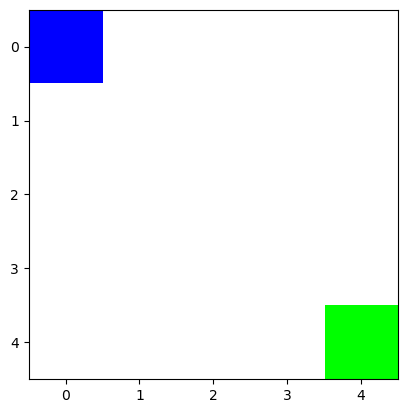

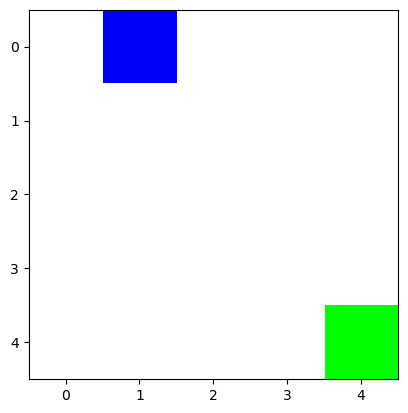

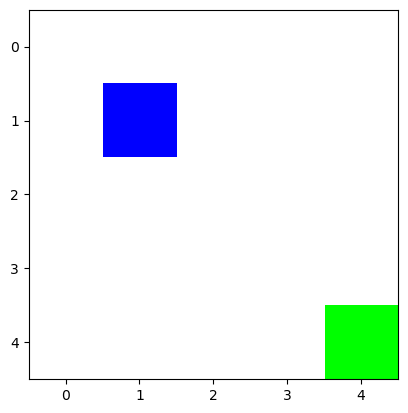

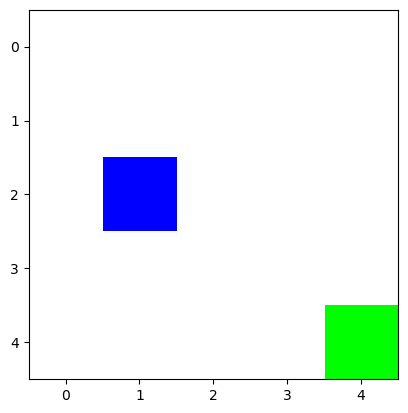

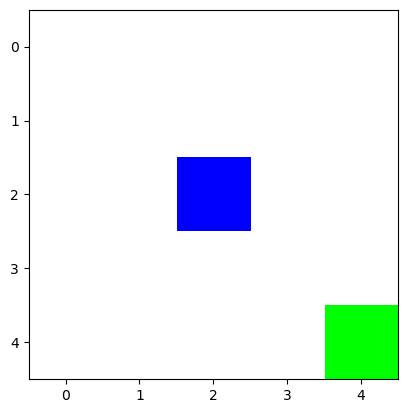

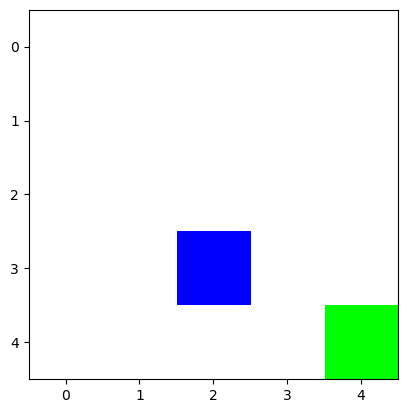

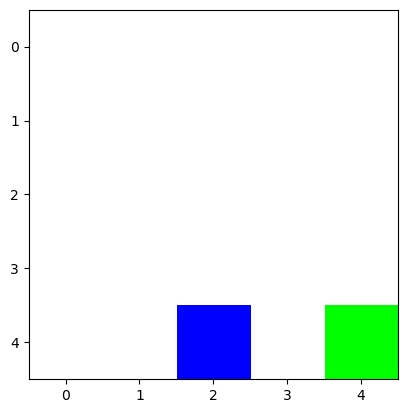

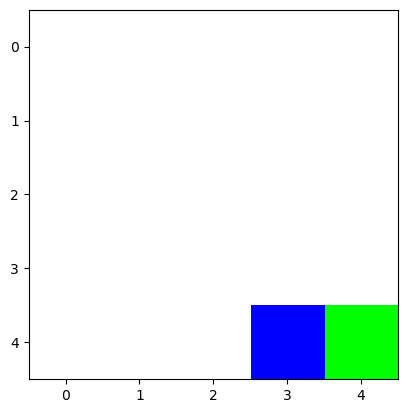

<Figure size 640x480 with 0 Axes>

In [17]:
def simulate_policy(env, policy, pause=0.5):
    state, _ = env.reset()

    done = False
    while not done:
        # Render
        img = env.render()
        if img is not None:
            plt.imshow(img)
            plt.axis('on')
            plt.show(block=False)
            plt.pause(pause)
            plt.clf()

        # Take action from policy
        action = policy[state]
        state, reward, done, _, _ = env.step(action)

simulate_policy(env, sarsa.policy, pause=0.7)

In [18]:
# Visualise the Value Function
def visualize_value_function(agent, agent_name="PI", env_size=5):
    """
    Display the state values as a heatmap.
    """
    plt.figure(figsize=(8, 6))
    
    # Populate the value grid with state values
    value_grid = np.array([np.max(agent.Q[state]) for state in range(num_states)]).reshape(env_size, env_size)
    
    # Create the heatmap visualization
    plt.imshow(value_grid, cmap='viridis')
    plt.colorbar(label='State Value')
    plt.title('Learned State Values')
    
    # Add value text in each cell for precision
    for row in range(env_size):
        for col in range(env_size):
            value = value_grid[row, col]
            text_color = "white" if value < 0.5 * np.max(value_grid) else "black"
            plt.text(col, row, f"{value:.2f}",
                     ha="center", va="center", color=text_color)
    plt.show()
    plt.savefig(f"visualisations/{agent_name}_value_function.png")
    plt.close()
    print("Value function visualisation saved")

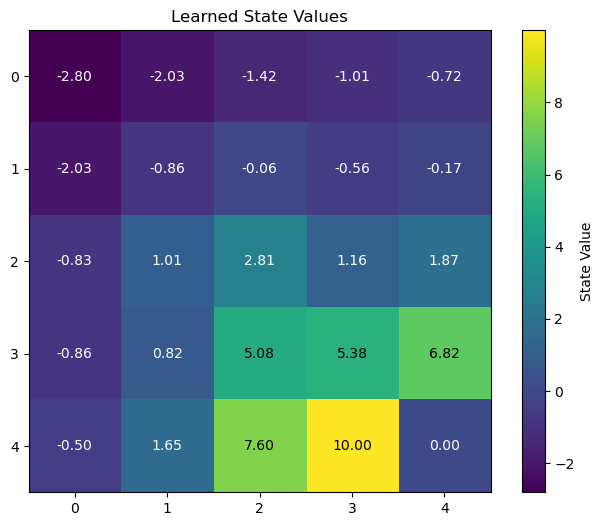

Value function visualisation saved


In [19]:
visualize_value_function(sarsa, agent_name="SARSA")